**라이브러리 임포트**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

**시각화 설정**

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

**데이터 불러오기**

In [ ]:
df = pd.read_csv('/content/AI_Personalized_Learning.csv')
print(f"데이터 로드 완료! Shape: {df.shape}")
print(f"컬럼: {df.columns.tolist()}")

데이터 로드 완료! Shape: (1000, 18)
컬럼: ['student_id', 'age', 'gender', 'education_level', 'learning_style', 'previous_gpa', 'completed_modules', 'avg_time_per_module', 'engagement_score', 'distraction_events', 'quiz_accuracy', 'feedback_score', 'contextual_difficulty_level', 'recommended_path', 'actual_path_followed', 'path_efficiency_score', 'final_assessment_score', 'learning_outcome']


**데이터 전처리,카테고리컬 변수 인코딩**

In [ ]:
label_encoders = {}
categorical_columns = ['gender', 'education_level', 'learning_style',
                      'contextual_difficulty_level', 'learning_outcome']

for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

**파생변수 생성**

In [ ]:
df['path_match'] = (df['recommended_path'] == df['actual_path_followed']).astype(int)

**탐색적 데이터분석 (EDA)**

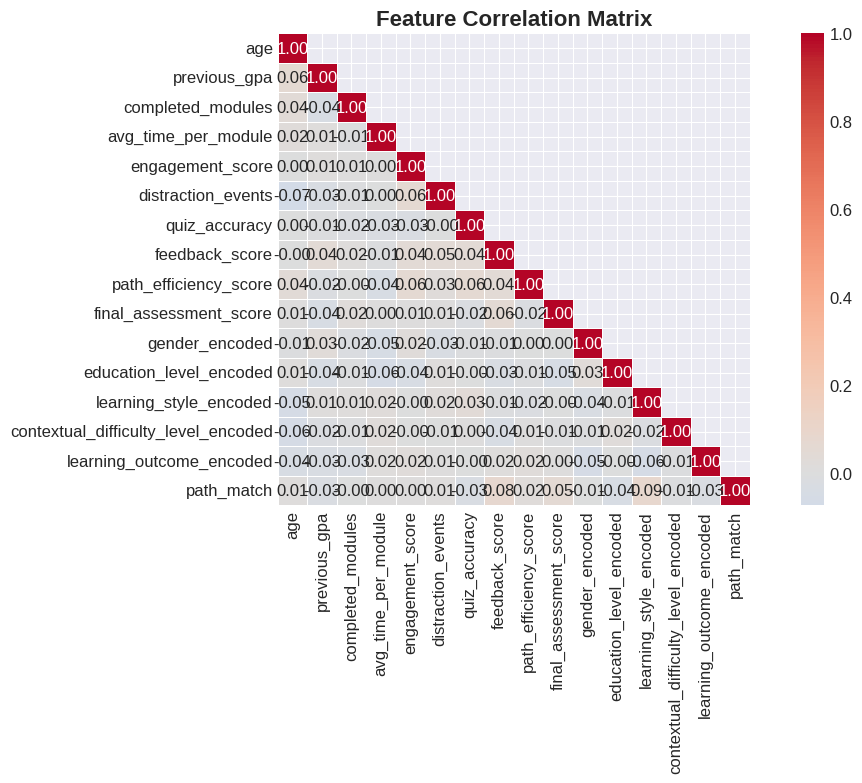

In [ ]:
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, fmt='.2f', square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**주요 통계량**

In [ ]:
key_stats = df[['previous_gpa', 'engagement_score', 'quiz_accuracy',
                'final_assessment_score']].describe()
print(key_stats.round(2))

       previous_gpa  engagement_score  quiz_accuracy  final_assessment_score
count       1000.00           1000.00        1000.00                 1000.00
mean           2.99             80.10          74.80                   80.45
std            0.57             12.09          14.83                   11.86
min            2.00             60.00          50.00                   60.00
25%            2.49             69.00          62.00                   71.00
50%            2.98             80.00          75.00                   81.00
75%            3.47             91.00          87.00                   91.00
max            3.99            100.00         100.00                  100.00


**모델준비 (특성과 타켓 변수 설정)**

In [ ]:
feature_columns = ['age', 'gender_encoded', 'education_level_encoded',
                  'learning_style_encoded', 'previous_gpa', 'completed_modules',
                  'avg_time_per_module', 'engagement_score', 'distraction_events',
                  'quiz_accuracy', 'feedback_score', 'contextual_difficulty_level_encoded',
                  'path_efficiency_score', 'path_match']

X = df[feature_columns]
y = df['final_assessment_score']

**데이터 분할과 스케일링**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"훈련 세트: {X_train.shape}")
print(f"테스트 세트: {X_test.shape}")

훈련 세트: (800, 14)
테스트 세트: (200, 14)


**모델학습과 성능평가**

In [ ]:
models = {
    'Linear': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=100)
}

baseline_results = {}

for name, model in models.items():
    # 모델 학습
    if name == 'Linear':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # 성능 평가
    baseline_results[name] = {
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

**결과 출력**

In [ ]:
results_df = pd.DataFrame(baseline_results).T
print(results_df.round(4))

                      R²       MSE      MAE     RMSE
Linear           -0.0579  162.6254  11.4071  12.7525
DecisionTree     -0.9938  306.4850  14.1550  17.5067
Random Forest    -0.0542  162.0483  11.3245  12.7298
GradientBoosting -0.1213  172.3715  11.5539  13.1290


**성능 시각화**

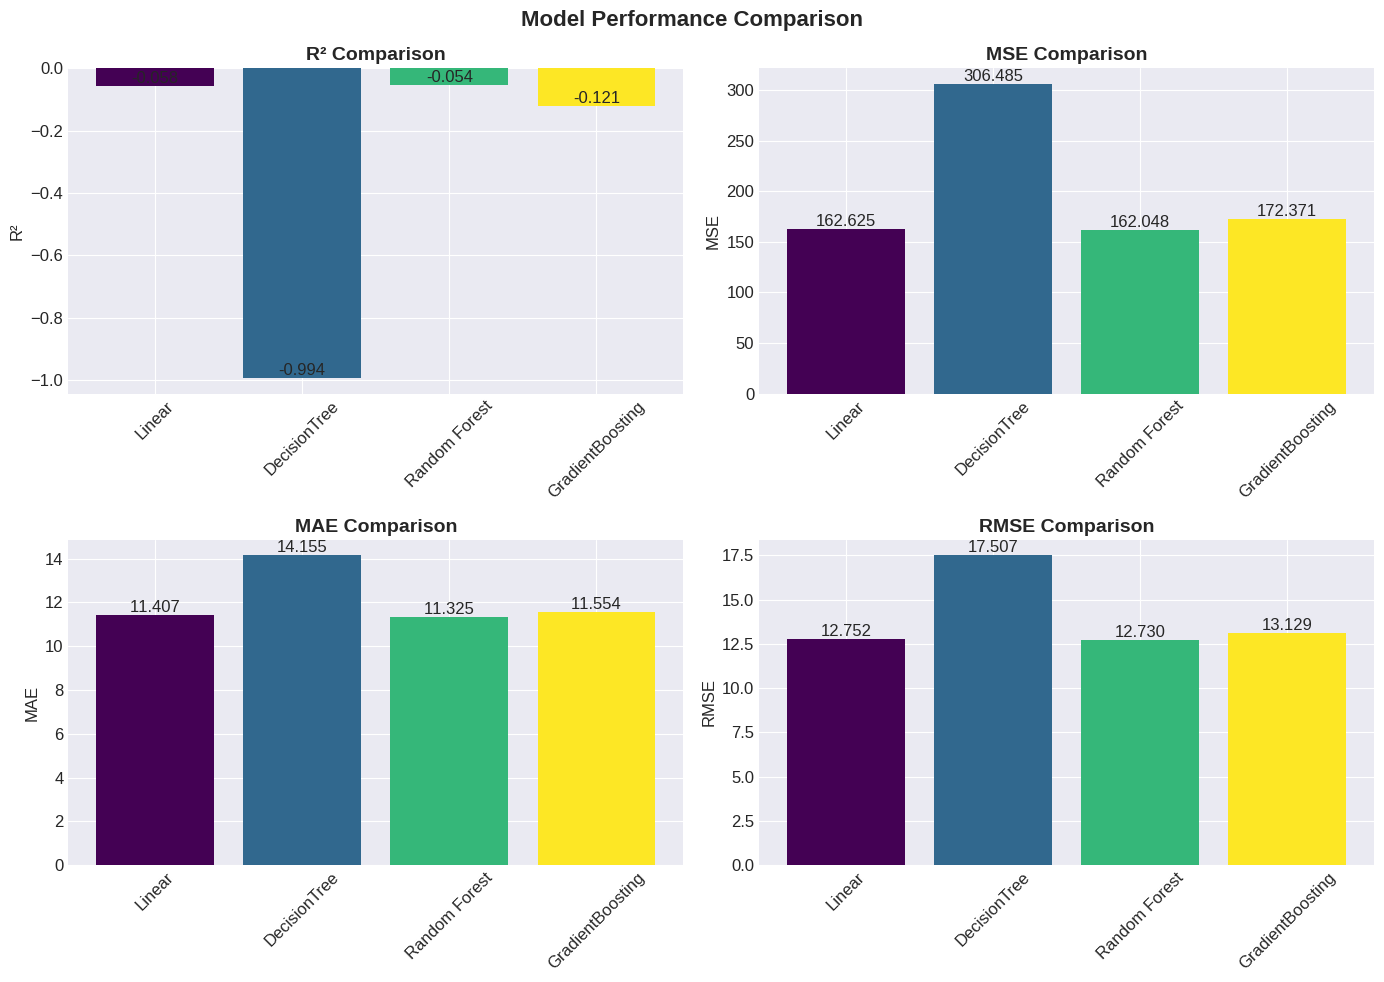

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['R²', 'MSE', 'MAE', 'RMSE']

for idx, metric in enumerate(metrics):
    ax_current = ax[idx//2, idx%2]
    values = results_df[metric]
    bars = ax_current.bar(values.index, values.values,
                          color=plt.cm.viridis(np.linspace(0, 1, len(values))))

    ax_current.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax_current.set_ylabel(metric)
    ax_current.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, values.values):
        ax_current.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                       f'{val:.3f}', ha='center', va='bottom')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**랜덤포레스트만 튜닝 (시간 절약을 위해)**

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최고 CV 점수: {grid_search.best_score_:.4f}")

최적 파라미터: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
최고 CV 점수: -0.0236


**최적 모델로 예측**

In [ ]:
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print(f"테스트 세트 R² (튜닝 후): {r2_score(y_test, y_pred_tuned):.4f}")

테스트 세트 R² (튜닝 후): -0.0540


** 앙상블 모델 (투표 아상블)**

In [ ]:
ensemble = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

ensemble_performance = {
    'R²': r2_score(y_test, y_pred_ensemble),
    'MSE': mean_squared_error(y_test, y_pred_ensemble),
    'MAE': mean_absolute_error(y_test, y_pred_ensemble)
}

print("앙상블 모델 성능:")
for metric, value in ensemble_performance.items():
    print(f"{metric}: {value:.4f}")

앙상블 모델 성능:
R²: -0.0756
MSE: 165.3453
MAE: 11.4016


**특성 중요도 분석 (랜덤포레스트 특성 중요도)**

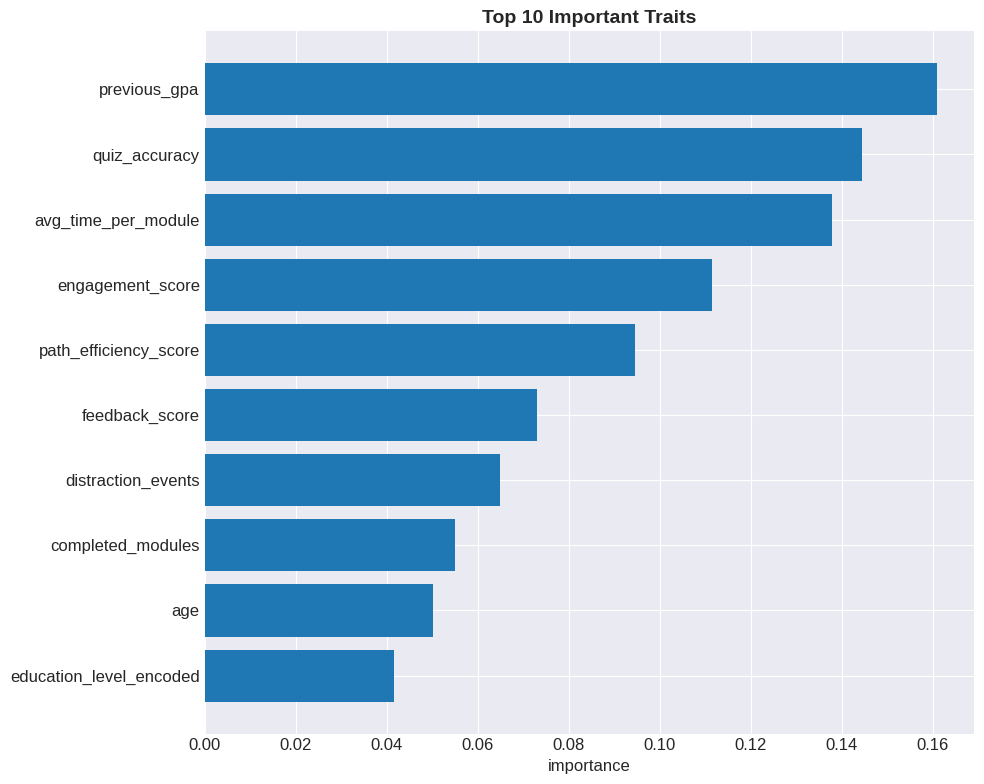


상위 5개 중요 특성:
                  feature  importance
4            previous_gpa    0.160967
9           quiz_accuracy    0.144317
6     avg_time_per_module    0.137920
7        engagement_score    0.111506
12  path_efficiency_score    0.094527


In [ ]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:10][::-1],
         feature_importance['importance'][:10][::-1])
plt.xlabel('importance')
plt.title('Top 10 Important Traits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n상위 5개 중요 특성:")
print(feature_importance.head())

**군집 분석을 통한 학습자 유형 분류**

In [ ]:
cluster_features = ['learning_style_encoded', 'previous_gpa',
                   'engagement_score', 'quiz_accuracy', 'avg_time_per_module']
X_cluster = df[cluster_features]

**K-means 클러스터링**

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

cluster_summary = df.groupby('cluster')[['previous_gpa', 'engagement_score',
                                        'quiz_accuracy', 'final_assessment_score']].mean()
print("\n클러스터별 평균 특성:")
print(cluster_summary.round(2))


클러스터별 평균 특성:
         previous_gpa  engagement_score  quiz_accuracy  final_assessment_score
cluster                                                                       
0                3.01             69.81          62.47                   80.10
1                2.94             77.74          87.45                   80.54
2                3.00             91.24          62.30                   80.85
3                3.00             81.65          87.18                   80.32


**시각화**

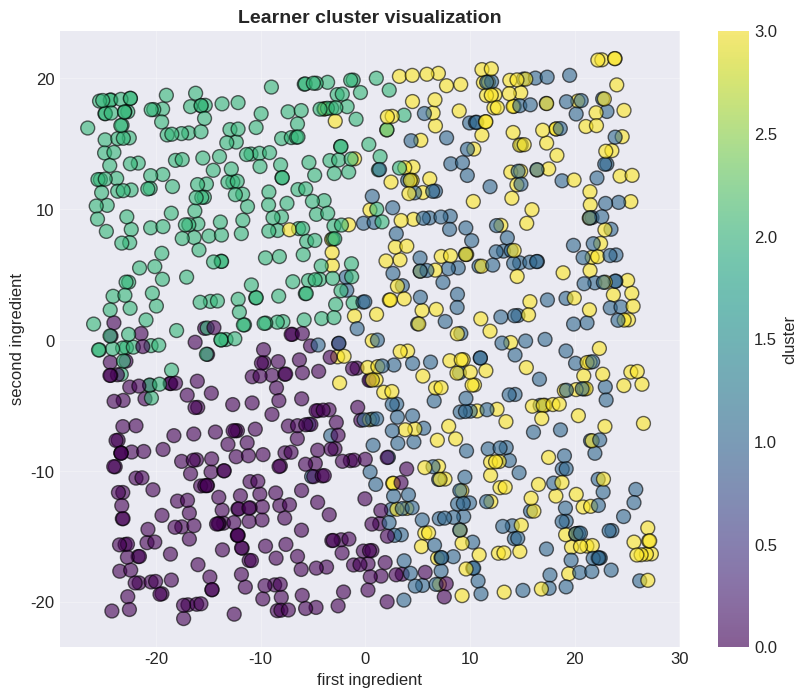

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=df['cluster'], cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black')
plt.xlabel('first ingredient')
plt.ylabel('second ingredient')
plt.title('Learner cluster visualization', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='cluster')
plt.grid(True, alpha=0.3)
plt.show()